In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.linalg import expm
from scipy.sparse.linalg import eigs
from scipy.special import factorial
from scipy.sparse import csr_matrix
import sys
sys.path.insert(0, "../")
import tools_graphs as tg
import cvxpy as cvx
import solvers as sv
from cvxopt import matrix
import time
from sklearn.cluster import k_means    

# Clustering-based on communicability
     1. Motivation
         1.1 Toy-example(not working with sampler. only kmeans)
     2. Examples(Exponential and Resolvent)
         2.1 sampling SBM
         2.1 clustering with adjacency
         2.2 clustering with exp(A)
         2.3 clustering with resolvent
         2.4 clustering Karate club
     3. Exploiting sparsity with Resolvent

### 1. Motivation
Most of the techniques for community detection are based on connections density. It is assumed that nodes within the same group are more highly connected than nodes from different groups. However, this is not the only criteria that can be used. For instance, it is a reasonable hypothesis that information flows better within groups. Following this intution Estrada proposed a communivability-based clustering in [Estrada & Naomichi (2009)](https://arxiv.org/pdf/0905.4103.pdf). It is also reasonable to assume that highly connected groups will score better communicability values, hence giving similar community estimations. However, here we show a toy-example where differences are illustrated


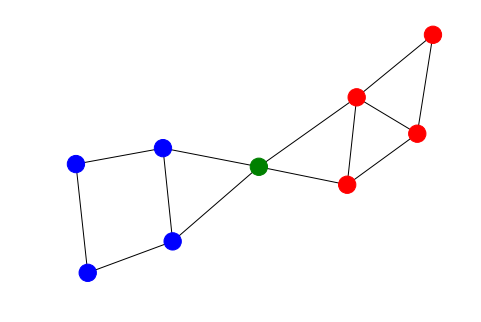

In [3]:
G = nx.Graph()
labels = ['r','r','r','r','g','b','b','b','b']
for i,label in enumerate(labels):
    G.add_node(i+1,attr_dict={'class':label})
G.add_edges_from([(1,2),(1,3),(1,4),(2,4),(3,4),
                  (3,5),(4,5),(5,6),(5,7),(6,7),(6,8),(8,9),(7,9)])
A = nx.to_scipy_sparse_matrix(G,dtype=np.float64)
node_color=[d['attr_dict']['class'] for x,d in G.nodes(data=True)]
nx.draw(G,node_color=node_color)
plt.rcParams["figure.figsize"] = (5,2)
plt.show()

Clustering based in just the adjacency matrix would assign sometimes the green node to the red cluster and sometimes to the blue cluster. However, community-based clustering would always assign the green node to the red group since it is more highly connected. 

In [4]:
#Solving opt with adjacency
def balanced_cut(Anp, labeling='sampling'):
    m,n = Anp.shape
    A = cvx.Parameter(m,n, value=Anp)
    X = cvx.Semidef(m)
    obj = cvx.Maximize(cvx.trace(X*A))
    constr_eq = [X[i,i]==1 for i in range(m)]
    constr_ineq = [cvx.trace(np.ones((m,n))*X) <= 1]
    prob = cvx.Problem(obj,constr_eq+constr_ineq)
    prob.solve(solver=cvx.MOSEK)
    #x.T*x solution. Need to sample one x.
    Vr,wr = sv.evd(matrix(X.value))
    if labeling =='sampling':
        x = sv.sampler(csr_matrix(Anp),Vr)
    else:
        inl, x,c = k_means(np.array(Vr),2)
    return x,X

#solver_adj = sv.SemidefCluster(assign_labels='kmeans')
#solver_adj.fit(A)
#solver_com = sv.SemidefCluster(assign_labels='kmeans')
eig,vec = np.linalg.eig(A.todense())
C = expm(A.todense()/(max(eig)))
C = csr_matrix(C)
#solver_com.fit(C)
#print("Adjacency-bases clustering: {}").format(solver_adj.labels_)
#print("Communicability-bases clustering: {}").format(solver_com.labels_)
x_ad,X = balanced_cut(A.todense(),labeling='kmeans')
x_com,X = balanced_cut(C,labeling='kmeans')
print("Adjacency-bases clustering: {}").format(x_ad)
print("Communica-bases clustering: {}").format(x_com)


Adjacency-bases clustering: [0 0 0 0 1 1 1 1 1]
Communica-bases clustering: [1 1 1 1 1 0 0 0 0]


### 2. Examples 

Examples of bigger networks

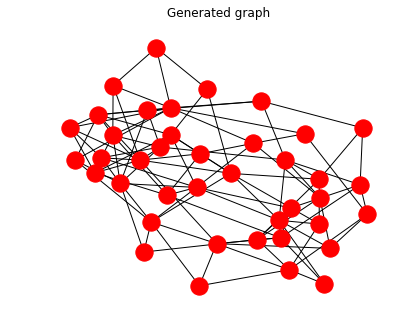

In [5]:
#Sampling net
N = 40
G,labels = tg.sample_SBM(N,0.2,0.05)
plt.rcParams["figure.figsize"] = (5,4)
A = np.array(nx.to_numpy_matrix(G,dtype=np.float64))
nx.draw(G); plt.title('Generated graph');plt.show()

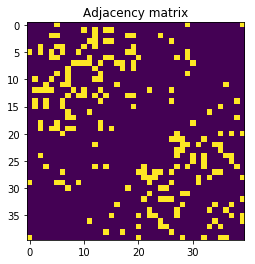

In [6]:
plt.imshow(A); plt.title('Adjacency matrix'); plt.show()
plt.rcParams["figure.figsize"] = (5,4)

Solving the following problem for $\delta = 1$

\begin{align*}
    \begin{array}{ll}
    \mbox{maximize} & \Tr (AX) \\
    \mbox{subject to} & X_{ii} = 1, \ i=1,\ldots,n\\
                      & \Tr (\ones^T\ones X) \leq \delta
    \end{array}
\end{align*}

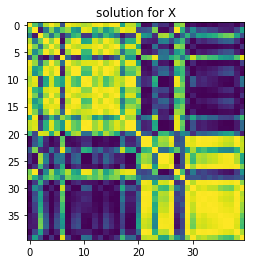

--- Solving time: 2.07138204575 seconds ---


In [172]:
#Solving opt problem
start_time = time.time()
x,X = balanced_cut(A,labeling='sampling')
t = time.time() - start_time
#x.T*x solution. Need to sample one x.
plt.imshow(X.value); plt.title('solution for X'); plt.show()
print("--- Solving time: %s seconds ---" % (t))

In [173]:
print x
print np.array(labels)

[1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]


Now solving for resolvent communicability 

\begin{align*}
    \begin{array}{ll}
    \mbox{maximize} & \Tr ((I-sA)^{-1}X) \\
    \mbox{subject to} & X_{ii} = 1, \ i=1,\ldots,n\\
                      &\Tr (\ones^T \ones X) \leq \delta
    \end{array}
\end{align*}

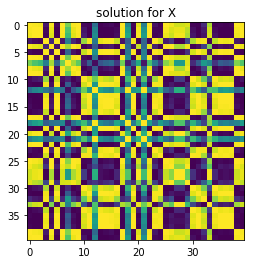

--- Solving time: 1.85243010521 seconds ---


In [269]:
#Solving opt problem
alpha = (1/float(N-1))
alpha = (.95/max(eig))
R = np.linalg.inv(np.eye(N)-alpha*A)

start_time = time.time()
x,X = balanced_cut(R)
t = time.time() - start_time
#x.T*x solution. Need to sample one x.
plt.imshow(X.value); plt.title('solution for X'); plt.show()
print("--- Solving time: %s seconds ---" % (t))

In [175]:
#Sampling from X=x^Tx to get labels assignment
Xp = matrix(X.value)
Vr,wr = sv.evd(Xp)
x = sv.sampler(csr_matrix(A),Vr)
print x
print np.array(labels)

[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]


Now solving for exponential communicability for $s=max(eig(A))$

\begin{align*}
    \begin{array}{ll}
    \mbox{maximize} & \Tr (exp^{sA}X) \\
    \mbox{subject to} & X_{ii} = 1, \ i=1,\ldots,n\\
                      & \Tr (\ones^{T} \ones X) \leq \delta
    \end{array}
\end{align*}

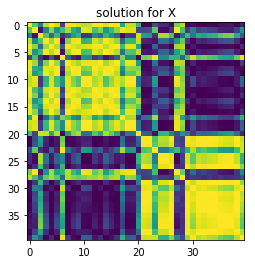

--- Solving time: 1.33344912529 seconds ---


In [176]:
#Solving opt problem
alpha = max(np.linalg.eig(A)[0])
C = expm((1/alpha)*A)
X = cvx.Semidef(N)
obj = cvx.Maximize(cvx.trace(C*X))
constr_eq = [X[i,i]==1 for i in range(N)]
constr_ineq = [cvx.trace(np.ones(C.shape)*X) <= 1]
prob = cvx.Problem(obj,constr_eq+constr_ineq)

start_time = time.time()
prob.solve(solver=cvx.MOSEK)
t = time.time() - start_time
#x.T*x solution. Need to sample one x.
plt.imshow(X.value); plt.title('solution for X'); plt.show()
print("--- Solving time: %s seconds ---" % (t))

### Karate club

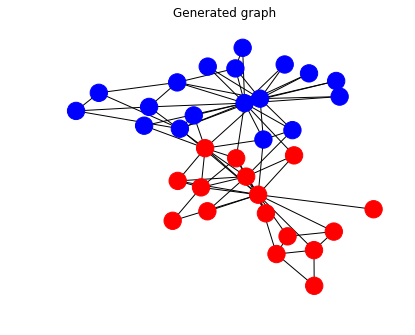

In [177]:
G = nx.read_gml('../karate.gml',label='id')
y_true = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
for i,(n,d) in enumerate(G.nodes(data=True)):
    if y_true[i]==0:
        d['class']='r'
    else:
        d['class']='b'
    
plt.rcParams["figure.figsize"] = (5,4)
A_karate = np.array(nx.to_numpy_matrix(G,dtype=np.float64))
node_color=[d['class'] for x,d in G.nodes(data=True)]
nx.draw(G,node_color=node_color); plt.title('Generated graph');plt.show()

In [178]:
#Sampling from X=x^Tx to get labels assignment
x,X = balanced_cut(A_karate)
print('Estimated: {}').format(x)
print('Truelabel: {}').format(np.array(y_true))

Estimated: [1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Truelabel: [0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1]


### Exploiting sparsity with communicability

In the first case, when clustering based on the adjacency matrix the problem can easily scale up due its sparsity. However when working with communicability matrices this i snot the case. The exponential is alawys dense as well as the inverse. However, in the case of the resolvent it is possible to make a change of variables which will mantain a considerable amount of sparsity. Firstly it is neccessary to remove the inverse with the change of variables $x = (I-sA)w$

\begin{align*}
    F(x) &= x^T(I-sA)^{-1}x\\
    F(w) &= w^T(I-sA)^T (I-sA)^{-1} (I-sA) w\\
    &= w^T(I-sA)^Tw
\end{align*}

Since A is sparse and symmetric, $(I-sA)^T$ is also sparse. Now working on the constraints.

\begin{align*}
    x_i^2 &= w^T(I-sA)^T e_i e_i^T (I-sA)w = 1 \\
    &= w^T(I-sA)^T E_i (I-sA)w = 1 \quad \text{for}\quad i =1,..n\\
\end{align*}

where $E_i \in R^{\ nxn}$ is a matrix of zeros expect fot $E_i[i,i] = 1$. Now the second constraint. 

\begin{align*}
    &x^T\ones \ones^Tx^T \leq \delta \\
    =& w^T(I-sA)^T \ones \ones ^T (I-sA)w = \leq \delta \\
\end{align*}

And finally by making the change of variables $ww^T = W$ and using the proporties of the trace operator we end up.

\begin{align*}
    \begin{array}{ll}
    \mbox{maximize} & \Tr (W(I-sA)^T) \\
    \mbox{subject to} & \Tr  (W(I-sA)^TE_i(I-sA)) = 1, \ i=1,\ldots,n\\
                      & \Tr (W(I-sA)^T\ones \ones^T(I-sA))  \leq \delta
    \end{array}
\end{align*}

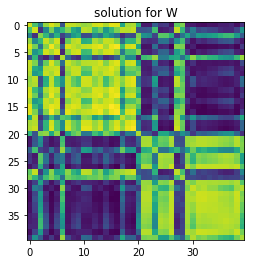

--- Solving time: 1.63602209091 seconds ---


In [179]:
#Solving opt problem
def Ei(i,N):
    ei = np.zeros((N,1))
    ei[i] = 1
    Ei = np.dot(ei,ei.T)
    return Ei

alpha = (1/float(N-1))
R = (np.eye(N)-alpha*A)
W = cvx.Semidef(N)
obj = cvx.Maximize(cvx.trace(R.T*W))
constr_eq = [cvx.trace(W*R.T*Ei(i,N)*R)==1 for i in range(N)]
constr_ineq = [cvx.trace(W*R.T*np.ones(R.shape)*R) <= 1]
prob = cvx.Problem(obj,constr_eq+constr_ineq)

start_time = time.time()
prob.solve()
t = time.time() - start_time

#w.T*w solution. Need to sample one w.
plt.rcParams["figure.figsize"] = (5,4)
plt.imshow(W.value); plt.title('solution for W'); plt.show()
print("--- Solving time: %s seconds ---" % (t))


Now for sampling we have to get one value of x, then make the change of variables and evaluate the objective until getting a good value.

In [180]:
from cvxopt import normal,blas
def sampler1(A,Vr,change_var=False, verbose=False):
    # Generate 1000 samples and apply rounding
    A = A.toarray()
    A[A==0.] = -1
    Am = matrix(A)
    vals = []
    fbest = float('-inf')
    xbest = None
    for k in range(10000):
        w = np.array([-1. if xi >=0 else 1. for xi in Vr*normal(Vr.size[1],1)])
        #change of variables
        x = matrix(np.dot((np.eye(N)-alpha*A),w))
        f = blas.dot(x,Am*x)
        if f > fbest:
            if verbose == True:
                print f
                print "with"
            fbest = f
            xbest = x
        vals.append(f)
    x1 = np.array([0 if xi >= 0.0 else 1 for xi in xbest])
    return x1

Wp = matrix(W.value)
Vr,wr = sv.evd(Wp)
x = sampler1(csr_matrix(A),Vr)
print x
print np.array(labels)

[1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]


##### Time to check sparsity of objective and constraints

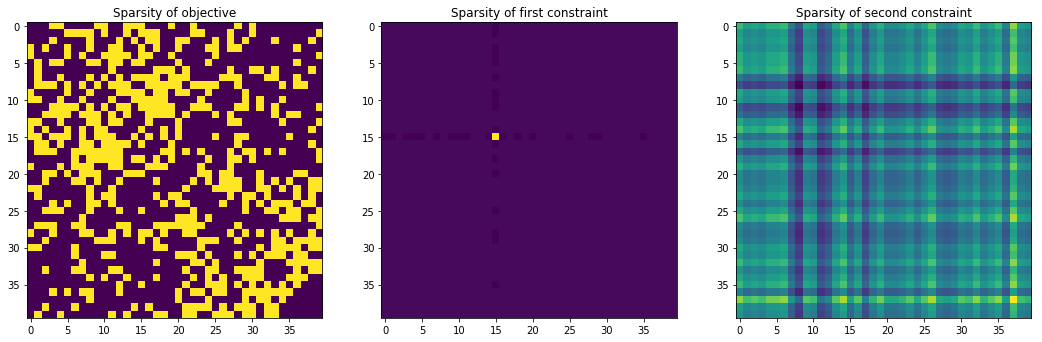

In [182]:
fig, axarr = plt.subplots(1,3)
plt.rcParams["figure.figsize"] = (18,16)
axarr[0].imshow(-(R-np.eye(N)))
axarr[0].set_title("Sparsity of objective")
axarr[1].imshow(np.dot(np.dot(R.T,Ei(15,N)),R))
axarr[1].set_title("Sparsity of first constraint")
axarr[2].imshow(np.dot(np.dot(R.T,np.ones(R.shape)),R))
axarr[2].set_title("Sparsity of second constraint")
plt.show()

#### Trying new reformulation of balanced cut

There is no sparsity...

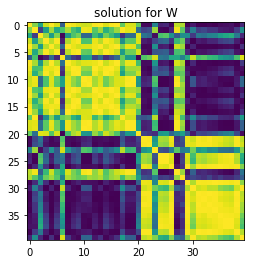

--- Solving time: 1.28431510925 seconds ---


In [183]:
gamma = 0.5
B = A-gamma*np.ones(A.shape)
X = cvx.Semidef(N)
obj = cvx.Maximize(cvx.trace(B*X))
constr_eq = [X[i,i]==1 for i in range(N)]
prob = cvx.Problem(obj,constr_eq)

start_time = time.time()
prob.solve()
t = time.time() - start_time
plt.rcParams["figure.figsize"] = (5,4)
plt.imshow(X.value); plt.title('solution for W'); plt.show()
print("--- Solving time: %s seconds ---" % (t))


In [184]:
Vr,wr = sv.evd(matrix(X.value))
x = sampler1(csr_matrix(B),Vr)
print x

[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0]


In [4]:
from cvxopt import amd,sparse
v = np.dot(np.ones(N),R)
def orthM(v,N):
    offdiag = [-v[i] for i in range(N-1)]
    diag = [v[i+1] for i in range(N-1)]+[v[-1]]
    F =  np.diag(diag)-np.diag(offdiag,-1)
    F[:,-1] = v
    F = (1/np.linalg.norm(v)**2)*F
    return F
R = (np.eye(N)-(0.95/max(eig))*A)
F = orthM(v,N)
p = amd.order(sparse(matrix(R)))
Rp = matrix(R)[p,p]
Ao = np.dot(F.T,np.dot(Rp,F))

Ac1 = np.dot(F.T,np.dot(R.T,np.dot(Ei(4,N),np.dot(R,F))))
Ac2 = np.dot(np.dot(v,F).reshape(N,1),np.dot(v,F).reshape(1,N))
print v.shape


NameError: name 'N' is not defined

In [3]:
plt.imshow(Ao[:39,:39])
plt.colorbar()
plt.rcParams["figure.figsize"] = (5,4)


NameError: name 'Ao' is not defined

12.447913676469827


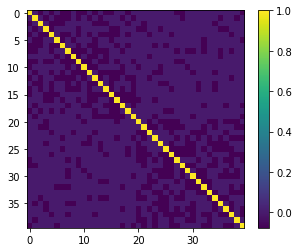

In [285]:
eig = np.linalg.eig(A)[0]
print max(eig)
plt.imshow((np.eye(N)-(0.95/max(eig))*A))
plt.colorbar()


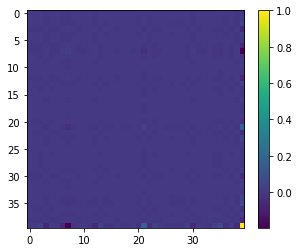

In [262]:
plt.imshow(Ac2)
plt.colorbar()
plt.rcParams["figure.figsize"] = (5,4)


In [103]:
alpha = (1/float(N-1))
R = (np.eye(N)-alpha*A)
W = cvx.Semidef(N)
obj = cvx.Maximize(cvx.trace(R.T*W))
constr_eq = [cvx.trace(W*R.T*Ei(i,N)*R)==1 for i in range(N)]
constr_ineq = [cvx.trace(W*R.T*np.ones(R.shape)*R) <= 1]
prob = cvx.Problem(obj,constr_eq+constr_ineq)

start_time = time.time()
prob.solve()
t = time.time() - start_time

#w.T*w solution. Need to sample one w.
plt.rcParams["figure.figsize"] = (5,4)
plt.imshow(W.value); plt.title('solution for W'); plt.show()
print("--- Solving time: %s seconds ---" % (t))


F = np.eye(N)-np.diag(np.ones(N-1),-1)
F[:,-1] = np.ones(N)
print F

[[ 1.  0.  0. ...  0.  0.  1.]
 [-1.  1.  0. ...  0.  0.  1.]
 [ 0. -1.  1. ...  0.  0.  1.]
 ...
 [ 0.  0.  0. ...  1.  0.  1.]
 [ 0.  0.  0. ... -1.  1.  1.]
 [ 0.  0.  0. ...  0. -1.  1.]]


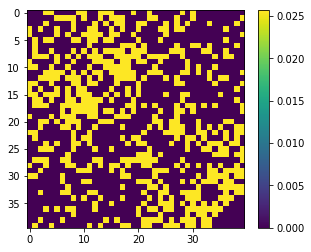

In [248]:
plt.imshow(-(R-np.eye(N)))
plt.colorbar()

In [236]:
help(amd.order)

Help on built-in function order in module cvxopt.amd:

order(...)
    Computes the approximate minimum degree ordering of a square matrix.
    
    p = order(A, uplo='L')
    
    PURPOSE
    Computes a permutation p that reduces fill-in in the Cholesky
    factorization of A[p,p].
    
    ARGUMENTS
    A         square sparse matrix
    
    uplo      'L' or 'U'.  If uplo is 'L', the lower triangular part
              of A is used and the upper triangular is ignored.  If
              uplo is 'U', the upper triangular part is used and the
              lower triangular part is ignored.
    
    p         'i' matrix of length equal to the order of A

